In [27]:
import os
import shutil
import xml.etree.ElementTree as ET
from PIL import Image
from sklearn.model_selection import train_test_split

# === CONFIG ===
input_dir = '.'  # Folder where your sunX.jpg and sunX.xml files are
output_dir = 'yolo_dataset'  # Output folder
img_size = (640, 640)
classes = ['sun']  # Define class list
val_split = 0.2

# === CREATE OUTPUT FOLDERS ===
image_out = os.path.join(output_dir, 'images')
label_out = os.path.join(output_dir, 'labels')
for split in ['train', 'val']:
    os.makedirs(os.path.join(image_out, split), exist_ok=True)
    os.makedirs(os.path.join(label_out, split), exist_ok=True)



In [28]:
# Gather all image-xml pairs
image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
image_ids = list(set([
    os.path.splitext(f)[0] for f in image_files
    if os.path.exists(os.path.join(input_dir, os.path.splitext(f)[0] + '.xml'))
]))

# Train/validation split
train_ids, val_ids = train_test_split(image_ids, test_size=val_split, random_state=42)


In [29]:
def convert_box(size, box):
    w_img, h_img = size
    x_center = (box[0] + box[1]) / 2.0
    y_center = (box[2] + box[3]) / 2.0
    width = box[1] - box[0]
    height = box[3] - box[2]
    return [x_center / w_img, y_center / h_img, width / w_img, height / h_img]


In [30]:
def process_pair(img_id, split):
    xml_path = os.path.join(input_dir, img_id + '.xml')
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Match image
    for ext in ['.jpg', '.jpeg', '.png']:
        img_path = os.path.join(input_dir, img_id + ext)
        if os.path.exists(img_path):
            break
    else:
        print(f"❌ Image not found for {img_id}")
        return

    # Open and resize image
    img = Image.open(img_path).convert('RGB')
    original_size = img.size
    img = img.resize(img_size, Image.Resampling.LANCZOS)
    out_img_name = img_id + '.png'
    img.save(os.path.join(image_out, split, out_img_name))

    # Extract bounding boxes
    label_lines = []
    for obj in root.findall('object'):
        cls_name = obj.find('name').text
        if cls_name not in classes:
            continue
        cls_id = classes.index(cls_name)
        xmlbox = obj.find('bndbox')
        b = [int(xmlbox.find('xmin').text),
             int(xmlbox.find('xmax').text),
             int(xmlbox.find('ymin').text),
             int(xmlbox.find('ymax').text)]

        scaled = [b[0] * img_size[0] / original_size[0],
                  b[1] * img_size[0] / original_size[0],
                  b[2] * img_size[1] / original_size[1],
                  b[3] * img_size[1] / original_size[1]]

        bbox = convert_box(img_size, scaled)
        label_lines.append(f"{cls_id} {' '.join(f'{x:.6f}' for x in bbox)}")

    label_path = os.path.join(label_out, split, img_id + '.txt')
    with open(label_path, 'w') as f:
        f.write('\n'.join(label_lines))


In [31]:
for img_id in train_ids:
    process_pair(img_id, 'train')

for img_id in val_ids:
    process_pair(img_id, 'val')

print("✅ All images and labels processed.")


✅ All images and labels processed.


In [32]:
yaml_path = os.path.join(output_dir, 'data.yaml')

with open(yaml_path, 'w') as f:
    f.write(f"""path: {os.path.abspath(output_dir)}
train: images/train
val: images/val
names:
  0: sun
""")

print(f"✅ data.yaml created at {yaml_path}")


✅ data.yaml created at yolo_dataset\data.yaml


In [49]:
from ultralytics import YOLO

# Load a pretrained model (e.g., YOLOv8 nano for speed)
model = YOLO('yolov8n.pt')

# Train the model on your dataset
model.train(
    data='yolo_dataset/data.yaml',
    epochs=400,
    imgsz=640,
    batch=8,
    device=0  # or 'cpu' if you're not using GPU
)



Ultralytics 8.3.127  Python-3.9.19 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=400, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train18, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, 

train: Scanning C:\Users\karth\OneDrive\Documents\GitHub\Solar_git\gk_stuff\images\yolo_dataset\labels\train.cache... 9 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9/9 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 986.5632.3 MB/s, size: 152.6 KB)


val: Scanning C:\Users\karth\OneDrive\Documents\GitHub\Solar_git\gk_stuff\images\yolo_dataset\labels\val.cache... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<?, ?it/s]


Plotting labels to c:\runs\detect\train18\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to c:\runs\detect\train18
Starting training for 400 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/400      1.22G      1.827      5.518      1.764          1        640: 100%|██████████| 2/2 [00:00<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.13it/s]

                   all          3          3          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/400      1.22G      1.356       4.49      1.415          2        640: 100%|██████████| 2/2 [00:00<00:00, 11.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.03it/s]

                   all          3          3          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/400      1.22G       2.24      7.547       1.18          2        640: 100%|██████████| 2/2 [00:00<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.10it/s]

                   all          3          3          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/400      1.22G      1.052      6.525     0.9678          0        640: 100%|██████████| 2/2 [00:00<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.46it/s]

                   all          3          3    0.00111      0.333   0.000894   8.94e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/400      1.22G     0.7793      6.009     0.7773          0        640: 100%|██████████| 2/2 [00:00<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.55it/s]

                   all          3          3    0.00111      0.333   0.000993   0.000365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/400      1.22G       1.45      4.484      1.345          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.78it/s]

                   all          3          3    0.00222      0.667      0.003    0.00141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/400      1.22G      1.107      5.893     0.9805          0        640: 100%|██████████| 2/2 [00:00<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.91it/s]

                   all          3          3    0.00222      0.667    0.00277     0.0015



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/400      1.22G     0.6942      5.947     0.6349          0        640: 100%|██████████| 2/2 [00:00<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.49it/s]

                   all          3          3    0.00222      0.667      0.003    0.00126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/400      1.22G     0.7576      5.663     0.6145          0        640: 100%|██████████| 2/2 [00:00<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.13it/s]

                   all          3          3    0.00222      0.667    0.00333    0.00149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/400      1.22G      1.641      3.272      1.356          3        640: 100%|██████████| 2/2 [00:00<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.85it/s]

                   all          3          3    0.00222      0.667    0.00353    0.00144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/400      1.22G      1.738      3.625      1.247          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.40it/s]

                   all          3          3    0.00222      0.667    0.00396     0.0017



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/400      1.23G      1.487      2.434      1.137          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.45it/s]

                   all          3          3    0.00222      0.667    0.00396     0.0017



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/400      1.24G      1.688      5.794      1.153          1        640: 100%|██████████| 2/2 [00:00<00:00, 11.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.37it/s]

                   all          3          3    0.00111      0.333    0.00125      0.001



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/400      1.24G       1.02      2.725      1.016          2        640: 100%|██████████| 2/2 [00:00<00:00, 13.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.80it/s]

                   all          3          3    0.00222      0.667     0.0026    0.00118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/400      1.24G      1.961      4.585      1.687          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.26it/s]

                   all          3          3    0.00222      0.667     0.0026    0.00118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/400      1.24G      1.593      2.661      1.082          1        640: 100%|██████████| 2/2 [00:00<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.89it/s]

                   all          3          3    0.00111      0.333   0.000799   0.000479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/400      1.24G      1.818      4.314      1.401          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.80it/s]

                   all          3          3    0.00111      0.333   0.000799    0.00024



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/400      1.24G      1.809      3.678      1.648          1        640: 100%|██████████| 2/2 [00:00<00:00, 11.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.78it/s]

                   all          3          3    0.00111      0.333   0.000799    0.00024



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/400      1.24G     0.6574      5.437     0.5796          0        640: 100%|██████████| 2/2 [00:00<00:00, 13.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.95it/s]

                   all          3          3          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/400      1.24G      1.753      3.576       1.39          2        640: 100%|██████████| 2/2 [00:00<00:00, 13.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.90it/s]

                   all          3          3          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/400      1.24G      1.437      3.342      1.425          4        640: 100%|██████████| 2/2 [00:00<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.85it/s]

                   all          3          3          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/400      1.25G      1.748      3.715      1.818          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.88it/s]

                   all          3          3          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/400      1.26G      1.438      2.564      1.225          3        640: 100%|██████████| 2/2 [00:00<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.46it/s]

                   all          3          3          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/400      1.28G     0.7258       5.24     0.6287          0        640: 100%|██████████| 2/2 [00:00<00:00, 17.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.51it/s]

                   all          3          3          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/400       1.3G      1.136      3.163      1.002          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.86it/s]

                   all          3          3          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/400      1.31G      1.578       2.85       1.39          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.83it/s]

                   all          3          3          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/400      1.33G      1.839      3.792       1.47          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.85it/s]

                   all          3          3          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/400      1.33G      1.413       3.38      1.115          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.37it/s]

                   all          3          3          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/400      1.33G      1.107      2.577      1.019          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.59it/s]

                   all          3          3          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/400      1.33G      1.233      2.782      1.226          4        640: 100%|██████████| 2/2 [00:00<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.99it/s]

                   all          3          3    0.00111      0.333   0.000801   0.000641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/400      1.33G       1.97      2.932      1.881          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.61it/s]

                   all          3          3    0.00111      0.333   0.000801   0.000641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/400      1.33G      1.847      3.806      1.205          2        640: 100%|██████████| 2/2 [00:00<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.85it/s]

                   all          3          3    0.00111      0.333   0.000801   0.000641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/400      1.33G     0.7901      5.173      0.639          0        640: 100%|██████████| 2/2 [00:00<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.01it/s]

                   all          3          3    0.00333          1     0.0171     0.0143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/400      1.33G      1.924      2.988      1.194          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.49it/s]

                   all          3          3    0.00333          1     0.0171     0.0143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/400      1.33G      1.277      2.419      1.239          1        640: 100%|██████████| 2/2 [00:00<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.96it/s]

                   all          3          3    0.00333          1     0.0171     0.0143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/400      1.33G      1.569      2.552      1.157          1        640: 100%|██████████| 2/2 [00:00<00:00, 11.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.91it/s]

                   all          3          3    0.00333          1      0.137     0.0929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/400      1.33G      1.656      2.282      1.391          2        640: 100%|██████████| 2/2 [00:00<00:00, 13.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.26it/s]

                   all          3          3    0.00333          1      0.137     0.0929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/400      1.33G      1.635      2.761       1.36          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.24it/s]

                   all          3          3    0.00333          1      0.137     0.0929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/400      1.33G     0.6996      4.947       0.71          0        640: 100%|██████████| 2/2 [00:00<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.15it/s]

                   all          3          3    0.00458          1     0.0747     0.0443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/400      1.33G      1.332      2.388      1.022          3        640: 100%|██████████| 2/2 [00:00<00:00, 15.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.65it/s]

                   all          3          3    0.00458          1     0.0747     0.0443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/400      1.33G      1.194      2.313      1.078          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.66it/s]

                   all          3          3    0.00458          1     0.0747     0.0443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/400      1.33G      1.233      2.137      1.266          2        640: 100%|██████████| 2/2 [00:00<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.96it/s]

                   all          3          3    0.00222      0.667    0.00328    0.00271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/400      1.33G      2.026      2.874      1.839          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 34.05it/s]

                   all          3          3    0.00222      0.667    0.00328    0.00271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/400      1.33G      1.896      2.437      1.425          4        640: 100%|██████████| 2/2 [00:00<00:00, 14.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.42it/s]

                   all          3          3    0.00222      0.667    0.00328    0.00271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/400      1.33G     0.8001      4.991     0.7071          0        640: 100%|██████████| 2/2 [00:00<00:00, 15.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.99it/s]

                   all          3          3    0.00222      0.667    0.00328    0.00271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/400      1.33G      1.299      2.314      1.087          2        640: 100%|██████████| 2/2 [00:00<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.35it/s]

                   all          3          3      0.948      0.333      0.378      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/400      1.33G      1.173      1.964       1.23          1        640: 100%|██████████| 2/2 [00:00<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.36it/s]

                   all          3          3      0.948      0.333      0.378      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/400      1.33G      1.258      1.814      1.011          2        640: 100%|██████████| 2/2 [00:00<00:00, 14.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.00it/s]

                   all          3          3      0.948      0.333      0.378      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/400      1.33G      1.039      5.111     0.9048          0        640: 100%|██████████| 2/2 [00:00<00:00, 16.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.62it/s]

                   all          3          3      0.948      0.333      0.378      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/400      1.33G      1.398      2.186      1.211          2        640: 100%|██████████| 2/2 [00:00<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.15it/s]

                   all          3          3      0.388      0.333      0.365      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/400      1.33G      2.375      4.279      2.111          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.82it/s]

                   all          3          3      0.388      0.333      0.365      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/400      1.33G      1.751      2.935      1.261          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 34.10it/s]

                   all          3          3      0.388      0.333      0.365      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/400      1.33G      1.988      3.076      1.409          2        640: 100%|██████████| 2/2 [00:00<00:00, 14.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.96it/s]

                   all          3          3      0.388      0.333      0.365      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/400      1.33G      1.188      2.633        1.2          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.55it/s]

                   all          3          3          1       0.66      0.665        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/400      1.33G       2.01      3.629      2.036          1        640: 100%|██████████| 2/2 [00:00<00:00, 11.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.75it/s]

                   all          3          3          1       0.66      0.665        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/400      1.33G     0.6477      4.646      0.649          0        640: 100%|██████████| 2/2 [00:00<00:00, 14.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.35it/s]

                   all          3          3          1       0.66      0.665        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/400      1.33G      1.697      2.654      1.511          3        640: 100%|██████████| 2/2 [00:00<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.19it/s]

                   all          3          3          1       0.66      0.665        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/400      1.33G       1.35      2.307      1.204          2        640: 100%|██████████| 2/2 [00:00<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.94it/s]

                   all          3          3          1      0.649      0.665      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/400      1.33G      1.622      2.485      1.484          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.76it/s]

                   all          3          3          1      0.649      0.665      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/400      1.33G      1.306      2.269       1.16          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.87it/s]

                   all          3          3          1      0.649      0.665      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/400      1.33G      2.531      3.459      1.125          3        640: 100%|██████████| 2/2 [00:00<00:00, 13.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.09it/s]

                   all          3          3          1      0.649      0.665      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/400      1.33G      1.474      2.588       1.25          1        640: 100%|██████████| 2/2 [00:00<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.05it/s]

                   all          3          3          1      0.642      0.665      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/400      1.33G      1.237      1.952      1.208          3        640: 100%|██████████| 2/2 [00:00<00:00, 14.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.25it/s]

                   all          3          3          1      0.642      0.665      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/400      1.33G      1.889      3.546      1.563          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.52it/s]

                   all          3          3          1      0.642      0.665      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/400      1.33G      1.159      2.091          1          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.77it/s]

                   all          3          3          1      0.642      0.665      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/400      1.33G      1.532      2.908      1.263          3        640: 100%|██████████| 2/2 [00:00<00:00, 14.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.77it/s]

                   all          3          3      0.612      0.667      0.555      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/400      1.33G      1.828      2.731      1.903          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.03it/s]

                   all          3          3      0.612      0.667      0.555      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/400      1.33G     0.5993      4.177     0.5974          0        640: 100%|██████████| 2/2 [00:00<00:00, 16.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.37it/s]

                   all          3          3      0.612      0.667      0.555      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/400      1.33G      1.582      2.874      1.227          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.26it/s]

                   all          3          3      0.612      0.667      0.555      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/400      1.33G      1.518      2.056      1.164          1        640: 100%|██████████| 2/2 [00:00<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.25it/s]

                   all          3          3          1      0.655      0.665        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/400      1.33G     0.6043      4.243     0.6238          0        640: 100%|██████████| 2/2 [00:00<00:00, 17.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.31it/s]

                   all          3          3          1      0.655      0.665        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/400      1.33G      1.337      2.382      1.228          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.30it/s]

                   all          3          3          1      0.655      0.665        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/400      1.33G      1.169      2.056      1.247          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.97it/s]

                   all          3          3          1      0.655      0.665        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/400      1.33G      1.077      1.959      1.075          2        640: 100%|██████████| 2/2 [00:00<00:00, 13.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.16it/s]

                   all          3          3       0.95      0.667      0.665      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/400      1.33G      1.102      1.722      1.175          3        640: 100%|██████████| 2/2 [00:00<00:00, 15.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.76it/s]

                   all          3          3       0.95      0.667      0.665      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/400      1.33G      1.352      1.894      1.243          2        640: 100%|██████████| 2/2 [00:00<00:00, 16.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.31it/s]

                   all          3          3       0.95      0.667      0.665      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/400      1.33G      1.427      2.534      1.392          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.57it/s]

                   all          3          3       0.95      0.667      0.665      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/400      1.33G      1.508      2.143      1.259          2        640: 100%|██████████| 2/2 [00:00<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.26it/s]

                   all          3          3      0.976      0.667      0.665      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/400      1.33G      1.837      2.073      1.394          3        640: 100%|██████████| 2/2 [00:00<00:00, 15.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.73it/s]

                   all          3          3      0.976      0.667      0.665      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/400      1.33G      1.045      2.277      1.197          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.24it/s]

                   all          3          3      0.976      0.667      0.665      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/400      1.33G     0.6981      4.113     0.6145          0        640: 100%|██████████| 2/2 [00:00<00:00, 14.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.87it/s]

                   all          3          3      0.976      0.667      0.665      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/400      1.33G      2.306      2.316      1.834          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.31it/s]

                   all          3          3      0.976      0.667      0.665        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/400      1.33G      1.475      2.241      1.168          3        640: 100%|██████████| 2/2 [00:00<00:00, 16.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.25it/s]

                   all          3          3      0.976      0.667      0.665        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/400      1.33G      1.473      1.815       1.09          2        640: 100%|██████████| 2/2 [00:00<00:00, 13.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.28it/s]

                   all          3          3      0.976      0.667      0.665        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/400      1.33G      1.191      1.934      1.195          2        640: 100%|██████████| 2/2 [00:00<00:00, 15.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.09it/s]

                   all          3          3      0.976      0.667      0.665        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/400      1.33G      1.361      2.131     0.9857          3        640: 100%|██████████| 2/2 [00:00<00:00, 13.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.16it/s]

                   all          3          3      0.976      0.667      0.665      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/400      1.33G      1.324      2.223      1.068          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.84it/s]

                   all          3          3      0.976      0.667      0.665      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/400      1.33G      1.722      2.451      1.322          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.35it/s]

                   all          3          3      0.976      0.667      0.665      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/400      1.33G      1.756      1.996      1.543          2        640: 100%|██████████| 2/2 [00:00<00:00, 14.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.74it/s]

                   all          3          3      0.976      0.667      0.665      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/400      1.33G      1.201      1.908      1.172          1        640: 100%|██████████| 2/2 [00:00<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.88it/s]

                   all          3          3          1      0.637      0.665        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/400      1.33G      1.115      2.004      1.192          2        640: 100%|██████████| 2/2 [00:00<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.31it/s]

                   all          3          3          1      0.637      0.665        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/400      1.33G     0.9287      2.077      1.065          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.27it/s]

                   all          3          3          1      0.637      0.665        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/400      1.33G     0.9403        1.8      1.074          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.75it/s]

                   all          3          3          1      0.637      0.665        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/400      1.33G      1.109      2.194      1.244          1        640: 100%|██████████| 2/2 [00:00<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.25it/s]

                   all          3          3      0.131      0.667      0.107     0.0777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/400      1.33G     0.6303      3.833     0.6582          0        640: 100%|██████████| 2/2 [00:00<00:00, 16.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.76it/s]

                   all          3          3      0.131      0.667      0.107     0.0777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/400      1.33G      1.317      2.146       1.09          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.33it/s]

                   all          3          3      0.131      0.667      0.107     0.0777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/400      1.33G      1.259      1.426      1.114          4        640: 100%|██████████| 2/2 [00:00<00:00, 15.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.25it/s]

                   all          3          3      0.131      0.667      0.107     0.0777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/400      1.33G      1.104      2.215      1.201          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.28it/s]

                   all          3          3      0.154      0.667      0.133     0.0804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/400      1.33G     0.9239      1.789      1.018          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.59it/s]

                   all          3          3      0.154      0.667      0.133     0.0804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/400      1.33G      1.017      2.214      1.145          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.41it/s]

                   all          3          3      0.154      0.667      0.133     0.0804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/400      1.33G      1.243      1.808      1.186          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.59it/s]

                   all          3          3      0.154      0.667      0.133     0.0804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/400      1.33G      1.206       1.71      1.149          4        640: 100%|██████████| 2/2 [00:00<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.14it/s]

                   all          3          3      0.191      0.333      0.131      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/400      1.33G      2.501        3.9      2.449          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.04it/s]

                   all          3          3      0.191      0.333      0.131      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/400      1.33G      2.284      2.549      1.347          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.01it/s]

                   all          3          3      0.191      0.333      0.131      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/400      1.33G     0.6747      3.467     0.6346          0        640: 100%|██████████| 2/2 [00:00<00:00, 15.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.00it/s]

                   all          3          3      0.191      0.333      0.131      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/400      1.33G      1.221      1.892      1.194          2        640: 100%|██████████| 2/2 [00:00<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.41it/s]

                   all          3          3     0.0669      0.667     0.0664     0.0396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/400      1.33G      1.076      2.096      1.231          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.25it/s]

                   all          3          3     0.0669      0.667     0.0664     0.0396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/400      1.33G      1.717      1.921      1.802          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.74it/s]

                   all          3          3     0.0669      0.667     0.0664     0.0396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/400      1.33G      1.871      2.005      1.302          2        640: 100%|██████████| 2/2 [00:00<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.77it/s]

                   all          3          3     0.0669      0.667     0.0664     0.0396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/400      1.33G     0.5282      3.726     0.5826          0        640: 100%|██████████| 2/2 [00:00<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.50it/s]

                   all          3          3          1      0.653      0.741      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/400      1.33G      1.075      1.582      1.078          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.28it/s]

                   all          3          3          1      0.653      0.741      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/400      1.33G     0.7815      3.504     0.7088          0        640: 100%|██████████| 2/2 [00:00<00:00, 16.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.46it/s]

                   all          3          3          1      0.653      0.741      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/400      1.33G      1.907      1.876      1.107          4        640: 100%|██████████| 2/2 [00:00<00:00, 14.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.74it/s]

                   all          3          3          1      0.653      0.741      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/400      1.33G       1.19      2.224      1.171          1        640: 100%|██████████| 2/2 [00:00<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.37it/s]

                   all          3          3      0.577      0.667      0.555      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/400      1.33G      1.618      1.964      1.065          3        640: 100%|██████████| 2/2 [00:00<00:00, 14.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.99it/s]

                   all          3          3      0.577      0.667      0.555      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/400      1.33G     0.6443      3.447      0.574          0        640: 100%|██████████| 2/2 [00:00<00:00, 15.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.83it/s]

                   all          3          3      0.577      0.667      0.555      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/400      1.33G      0.936      1.506      1.172          3        640: 100%|██████████| 2/2 [00:00<00:00, 14.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.88it/s]

                   all          3          3      0.577      0.667      0.555      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/400      1.33G     0.8945      1.423     0.9768          2        640: 100%|██████████| 2/2 [00:00<00:00, 11.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.87it/s]

                   all          3          3          1      0.644      0.665      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/400      1.33G      1.027      1.792      1.041          2        640: 100%|██████████| 2/2 [00:00<00:00, 14.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.18it/s]


                   all          3          3          1      0.644      0.665      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/400      1.33G     0.6407      3.499     0.6573          0        640: 100%|██████████| 2/2 [00:00<00:00, 14.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.33it/s]

                   all          3          3          1      0.644      0.665      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/400      1.33G     0.8706      1.525     0.9226          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.97it/s]

                   all          3          3          1      0.644      0.665      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/400      1.33G     0.6796      3.537     0.6871          0        640: 100%|██████████| 2/2 [00:00<00:00, 14.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.80it/s]

                   all          3          3          1      0.661      0.665      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/400      1.33G      1.598      2.945      1.366          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.69it/s]

                   all          3          3          1      0.661      0.665      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/400      1.33G      1.556      2.424      1.277          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.86it/s]

                   all          3          3          1      0.661      0.665      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/400      1.33G      1.051      1.728      1.273          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.42it/s]

                   all          3          3          1      0.661      0.665      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/400      1.33G      1.827      3.849      1.283          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.47it/s]

                   all          3          3      0.979      0.667      0.665        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/400      1.33G      1.206      1.616      1.128          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.83it/s]

                   all          3          3      0.979      0.667      0.665        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/400      1.33G      1.276       2.52      1.236          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.64it/s]

                   all          3          3      0.979      0.667      0.665        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/400      1.33G      1.094      1.338      1.025          4        640: 100%|██████████| 2/2 [00:00<00:00, 16.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.34it/s]

                   all          3          3      0.979      0.667      0.665        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/400      1.33G     0.6227      3.629     0.5787          0        640: 100%|██████████| 2/2 [00:00<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.98it/s]

                   all          3          3      0.981      0.667      0.665        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/400      1.33G       1.06      2.004       1.02          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.55it/s]

                   all          3          3      0.981      0.667      0.665        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/400      1.33G       1.26      1.431     0.9803          2        640: 100%|██████████| 2/2 [00:00<00:00, 16.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.67it/s]

                   all          3          3      0.981      0.667      0.665        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/400      1.33G     0.9328      2.456      1.153          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.06it/s]

                   all          3          3      0.981      0.667      0.665        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/400      1.33G     0.6362      3.197     0.6618          0        640: 100%|██████████| 2/2 [00:00<00:00, 15.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.21it/s]

                   all          3          3      0.383      0.667      0.267      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/400      1.33G       1.04       1.49      1.152          2        640: 100%|██████████| 2/2 [00:00<00:00, 16.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.70it/s]

                   all          3          3      0.383      0.667      0.267      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/400      1.33G     0.7636      1.132     0.9738          2        640: 100%|██████████| 2/2 [00:00<00:00, 15.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.90it/s]

                   all          3          3      0.383      0.667      0.267      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/400      1.33G      1.671      2.122      1.613          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.58it/s]

                   all          3          3      0.383      0.667      0.267      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/400      1.33G      1.296      1.804      1.162          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.65it/s]

                   all          3          3      0.855      0.333       0.41      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/400      1.33G      1.151      1.305      1.233          4        640: 100%|██████████| 2/2 [00:00<00:00, 16.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.07it/s]

                   all          3          3      0.855      0.333       0.41      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/400      1.33G      1.005      1.568      1.111          2        640: 100%|██████████| 2/2 [00:00<00:00, 16.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.21it/s]

                   all          3          3      0.855      0.333       0.41      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/400      1.33G      1.074      1.582      1.217          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 34.12it/s]

                   all          3          3      0.855      0.333       0.41      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/400      1.33G      1.638      2.852       1.69          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.72it/s]

                   all          3          3      0.294      0.333      0.401      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/400      1.33G     0.9741      3.587     0.8018          0        640: 100%|██████████| 2/2 [00:00<00:00, 16.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.97it/s]

                   all          3          3      0.294      0.333      0.401      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/400      1.33G      1.487      2.261      1.706          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.25it/s]

                   all          3          3      0.294      0.333      0.401      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/400      1.33G      1.366      1.547      1.345          2        640: 100%|██████████| 2/2 [00:00<00:00, 15.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.26it/s]

                   all          3          3      0.294      0.333      0.401      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/400      1.33G      1.431      1.673      1.059          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.26it/s]

                   all          3          3      0.259      0.333      0.338      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/400      1.33G       1.49       1.54      1.079          2        640: 100%|██████████| 2/2 [00:00<00:00, 15.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.34it/s]

                   all          3          3      0.259      0.333      0.338      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/400      1.33G      1.177      2.107      1.297          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.89it/s]

                   all          3          3      0.259      0.333      0.338      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/400      1.33G      1.101      2.649       1.05          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.29it/s]

                   all          3          3      0.259      0.333      0.338      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/400      1.33G      1.219      1.242      1.249          3        640: 100%|██████████| 2/2 [00:00<00:00, 14.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.25it/s]

                   all          3          3      0.483      0.333      0.409      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/400      1.33G      1.283      2.194      1.492          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.25it/s]

                   all          3          3      0.483      0.333      0.409      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/400      1.33G      1.293      1.635      1.171          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.25it/s]

                   all          3          3      0.483      0.333      0.409      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/400      1.33G      1.154      1.363     0.9727          2        640: 100%|██████████| 2/2 [00:00<00:00, 16.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.25it/s]

                   all          3          3      0.483      0.333      0.409      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/400      1.33G      1.542      2.792      1.727          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.49it/s]

                   all          3          3      0.981      0.667       0.83      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/400      1.33G     0.4367      2.908      0.519          0        640: 100%|██████████| 2/2 [00:00<00:00, 17.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.97it/s]

                   all          3          3      0.981      0.667       0.83      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/400      1.33G      1.446      1.588      1.234          4        640: 100%|██████████| 2/2 [00:00<00:00, 13.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.89it/s]

                   all          3          3      0.981      0.667       0.83      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/400      1.33G       1.34      1.603      1.049          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.37it/s]

                   all          3          3      0.981      0.667       0.83      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/400      1.33G     0.8618      1.121     0.9537          2        640: 100%|██████████| 2/2 [00:00<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.58it/s]

                   all          3          3      0.741      0.963      0.913      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/400      1.33G      1.574      2.626       1.68          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.32it/s]

                   all          3          3      0.741      0.963      0.913      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/400      1.33G     0.9972      1.285      1.095          2        640: 100%|██████████| 2/2 [00:00<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.32it/s]

                   all          3          3      0.741      0.963      0.913      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/400      1.33G       1.09      1.361      1.152          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.33it/s]

                   all          3          3      0.741      0.963      0.913      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/400      1.33G       1.26       1.44      1.329          1        640: 100%|██████████| 2/2 [00:00<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.50it/s]

                   all          3          3          1      0.667      0.789      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/400      1.33G      1.245      1.229      1.152          2        640: 100%|██████████| 2/2 [00:00<00:00, 14.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.71it/s]

                   all          3          3          1      0.667      0.789      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/400      1.33G     0.6311      2.981     0.6007          0        640: 100%|██████████| 2/2 [00:00<00:00, 15.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.98it/s]

                   all          3          3          1      0.667      0.789      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/400      1.33G      0.998      1.643      1.168          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.27it/s]

                   all          3          3          1      0.667      0.789      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/400      1.33G     0.9467      1.394      1.096          1        640: 100%|██████████| 2/2 [00:00<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.15it/s]

                   all          3          3      0.975      0.667      0.806      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/400      1.33G      1.182      1.429      1.175          2        640: 100%|██████████| 2/2 [00:00<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.04it/s]

                   all          3          3      0.975      0.667      0.806      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/400      1.33G      1.122      1.493      1.039          3        640: 100%|██████████| 2/2 [00:00<00:00, 14.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.54it/s]

                   all          3          3      0.975      0.667      0.806      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/400      1.33G     0.4572      2.815     0.4954          0        640: 100%|██████████| 2/2 [00:00<00:00, 17.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.91it/s]

                   all          3          3      0.975      0.667      0.806      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/400      1.33G      1.249        1.4      1.099          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.86it/s]

                   all          3          3      0.978      0.667      0.913      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/400      1.33G      1.208      1.417      1.116          2        640: 100%|██████████| 2/2 [00:00<00:00, 15.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.75it/s]

                   all          3          3      0.978      0.667      0.913      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/400      1.33G      1.051      1.232      1.068          3        640: 100%|██████████| 2/2 [00:00<00:00, 13.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.94it/s]

                   all          3          3      0.978      0.667      0.913      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/400      1.33G      1.464       2.43     0.9867          2        640: 100%|██████████| 2/2 [00:00<00:00, 16.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.48it/s]

                   all          3          3      0.978      0.667      0.913      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/400      1.33G     0.8813      1.249     0.9271          4        640: 100%|██████████| 2/2 [00:00<00:00, 14.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.80it/s]

                   all          3          3      0.977      0.667      0.696      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/400      1.33G      1.403      1.863      1.662          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.02it/s]

                   all          3          3      0.977      0.667      0.696      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/400      1.33G      1.337      1.379      1.325          2        640: 100%|██████████| 2/2 [00:00<00:00, 15.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.49it/s]

                   all          3          3      0.977      0.667      0.696      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/400      1.33G     0.6712      2.916     0.7069          0        640: 100%|██████████| 2/2 [00:00<00:00, 16.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.55it/s]

                   all          3          3      0.977      0.667      0.696      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/400      1.33G     0.9433      1.468      1.002          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.02it/s]

                   all          3          3       0.98      0.667      0.736       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/400      1.33G       1.24      1.365       1.26          2        640: 100%|██████████| 2/2 [00:00<00:00, 15.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.52it/s]


                   all          3          3       0.98      0.667      0.736       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/400      1.33G      1.247        1.6      1.284          3        640: 100%|██████████| 2/2 [00:00<00:00, 14.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.13it/s]

                   all          3          3       0.98      0.667      0.736       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/400      1.33G      1.204      1.539      1.318          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.17it/s]

                   all          3          3       0.98      0.667      0.736       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/400      1.33G      1.223      1.579      1.136          2        640: 100%|██████████| 2/2 [00:00<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.24it/s]

                   all          3          3      0.981      0.667      0.755      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/400      1.33G        1.5      1.474       1.31          2        640: 100%|██████████| 2/2 [00:00<00:00, 13.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.45it/s]

                   all          3          3      0.981      0.667      0.755      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/400      1.33G      1.158      1.513      1.526          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.00it/s]

                   all          3          3      0.981      0.667      0.755      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/400      1.33G     0.5334      3.125     0.5172          0        640: 100%|██████████| 2/2 [00:00<00:00, 15.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.65it/s]

                   all          3          3      0.981      0.667      0.755      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/400      1.33G     0.4758      2.653     0.5037          0        640: 100%|██████████| 2/2 [00:00<00:00, 14.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.21it/s]

                   all          3          3      0.981      0.667      0.764      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/400      1.33G     0.8596      1.054      1.048          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.84it/s]

                   all          3          3      0.981      0.667      0.764      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/400      1.33G     0.9291      1.196      1.009          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.77it/s]

                   all          3          3      0.981      0.667      0.764      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/400      1.33G     0.9551      3.323      1.518          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 34.48it/s]

                   all          3          3      0.981      0.667      0.764      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/400      1.33G     0.6612      2.727     0.7195          0        640: 100%|██████████| 2/2 [00:00<00:00, 14.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.81it/s]

                   all          3          3       0.98      0.667      0.913       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/400      1.33G       1.07      1.455       1.26          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.06it/s]

                   all          3          3       0.98      0.667      0.913       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/400      1.33G     0.6775      2.685     0.6823          0        640: 100%|██████████| 2/2 [00:00<00:00, 16.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.30it/s]

                   all          3          3       0.98      0.667      0.913       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/400      1.33G      1.256      1.359      1.118          2        640: 100%|██████████| 2/2 [00:00<00:00, 15.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.46it/s]

                   all          3          3       0.98      0.667      0.913       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/400      1.33G      1.926      2.286      1.108          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.39it/s]

                   all          3          3          1      0.981      0.995      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/400      1.33G     0.8119      1.345      1.007          2        640: 100%|██████████| 2/2 [00:00<00:00, 14.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.78it/s]

                   all          3          3          1      0.981      0.995      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/400      1.33G       2.11      1.907      1.967          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.33it/s]

                   all          3          3          1      0.981      0.995      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/400      1.33G      1.308        1.5      1.307          3        640: 100%|██████████| 2/2 [00:00<00:00, 14.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.41it/s]

                   all          3          3          1      0.981      0.995      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/400      1.33G     0.8858      1.381     0.9412          1        640: 100%|██████████| 2/2 [00:00<00:00, 11.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.47it/s]

                   all          3          3          1      0.977      0.995      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/400      1.33G      1.192      1.351     0.9398          1        640: 100%|██████████| 2/2 [00:00<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.16it/s]

                   all          3          3          1      0.977      0.995      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/400      1.33G       1.14      1.295      1.133          3        640: 100%|██████████| 2/2 [00:00<00:00, 15.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.82it/s]

                   all          3          3          1      0.977      0.995      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/400      1.33G     0.5332      2.541     0.5888          0        640: 100%|██████████| 2/2 [00:00<00:00, 16.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.81it/s]

                   all          3          3          1      0.977      0.995      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/400      1.33G      1.092       1.22      1.067          1        640: 100%|██████████| 2/2 [00:00<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.09it/s]

                   all          3          3          1       0.97      0.995      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/400      1.33G      1.206      1.147      1.041          2        640: 100%|██████████| 2/2 [00:00<00:00, 15.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.53it/s]

                   all          3          3          1       0.97      0.995      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/400      1.33G      0.823      1.198      1.048          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.37it/s]

                   all          3          3          1       0.97      0.995      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/400      1.33G     0.6826      3.014     0.5919          0        640: 100%|██████████| 2/2 [00:00<00:00, 17.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.78it/s]

                   all          3          3          1       0.97      0.995      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/400      1.33G      1.042      1.361      1.013          1        640: 100%|██████████| 2/2 [00:00<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.29it/s]

                   all          3          3      0.978      0.667      0.806      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/400      1.33G      1.474      1.608      1.294          2        640: 100%|██████████| 2/2 [00:00<00:00, 14.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.99it/s]


                   all          3          3      0.978      0.667      0.806      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/400      1.33G      0.879      1.178     0.9182          3        640: 100%|██████████| 2/2 [00:00<00:00, 14.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.66it/s]

                   all          3          3      0.978      0.667      0.806      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/400      1.33G      1.059      1.252      1.063          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.86it/s]

                   all          3          3      0.978      0.667      0.806      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/400      1.33G      1.248      1.499      1.341          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.51it/s]

                   all          3          3      0.976      0.667      0.727      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/400      1.33G     0.4689      2.422     0.4959          0        640: 100%|██████████| 2/2 [00:00<00:00, 18.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.48it/s]

                   all          3          3      0.976      0.667      0.727      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/400      1.33G     0.9428      1.473      1.024          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.66it/s]

                   all          3          3      0.976      0.667      0.727      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/400      1.33G     0.9032      1.214     0.9148          2        640: 100%|██████████| 2/2 [00:00<00:00, 16.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.76it/s]

                   all          3          3      0.976      0.667      0.727      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/400      1.33G       1.02      1.463     0.9076          1        640: 100%|██████████| 2/2 [00:00<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.75it/s]

                   all          3          3      0.975      0.667      0.913      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/400      1.33G     0.7853      1.152     0.9487          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.34it/s]

                   all          3          3      0.975      0.667      0.913      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/400      1.33G     0.9163       1.08      0.922          4        640: 100%|██████████| 2/2 [00:00<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.13it/s]

                   all          3          3      0.975      0.667      0.913      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/400      1.33G     0.8071      1.222      0.772          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.86it/s]

                   all          3          3      0.975      0.667      0.913      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/400      1.33G     0.9295       1.24      1.101          2        640: 100%|██████████| 2/2 [00:00<00:00, 13.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.79it/s]

                   all          3          3      0.979      0.667       0.83      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/400      1.33G      0.333      2.283     0.4468          0        640: 100%|██████████| 2/2 [00:00<00:00, 16.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.25it/s]

                   all          3          3      0.979      0.667       0.83      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/400      1.33G     0.5245      2.457     0.5974          0        640: 100%|██████████| 2/2 [00:00<00:00, 18.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.73it/s]

                   all          3          3      0.979      0.667       0.83      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/400      1.33G     0.8883      1.307     0.9783          2        640: 100%|██████████| 2/2 [00:00<00:00, 16.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.26it/s]

                   all          3          3      0.979      0.667       0.83      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/400      1.33G     0.9205      1.205     0.8307          2        640: 100%|██████████| 2/2 [00:00<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.78it/s]

                   all          3          3          1      0.978      0.995      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/400      1.33G      0.983     0.9543      0.987          2        640: 100%|██████████| 2/2 [00:00<00:00, 15.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.57it/s]

                   all          3          3          1      0.978      0.995      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/400      1.33G     0.8612      1.153     0.9752          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.24it/s]

                   all          3          3          1      0.978      0.995      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/400      1.33G     0.9009      1.135     0.9506          4        640: 100%|██████████| 2/2 [00:00<00:00, 15.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.28it/s]

                   all          3          3          1      0.978      0.995      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/400      1.33G       1.35      2.012     0.9769          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.26it/s]

                   all          3          3          1      0.978      0.995      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/400      1.33G     0.8391       1.31     0.9668          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.78it/s]

                   all          3          3          1      0.978      0.995      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/400      1.33G     0.9621      1.333      1.003          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.57it/s]

                   all          3          3          1      0.978      0.995      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/400      1.33G     0.9114     0.9132     0.9469          2        640: 100%|██████████| 2/2 [00:00<00:00, 15.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.25it/s]

                   all          3          3          1      0.978      0.995      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/400      1.33G      1.121      1.435      1.218          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.07it/s]

                   all          3          3      0.982      0.667      0.913      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/400      1.33G      1.161      1.344      1.183          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.73it/s]

                   all          3          3      0.982      0.667      0.913      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/400      1.33G     0.9833      1.218       1.06          2        640: 100%|██████████| 2/2 [00:00<00:00, 15.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 34.74it/s]

                   all          3          3      0.982      0.667      0.913      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/400      1.33G     0.8438     0.9903     0.9196          2        640: 100%|██████████| 2/2 [00:00<00:00, 16.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.92it/s]

                   all          3          3      0.982      0.667      0.913      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/400      1.33G     0.4924      2.339     0.5629          0        640: 100%|██████████| 2/2 [00:00<00:00, 15.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.07it/s]

                   all          3          3       0.98      0.667      0.775      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/400      1.33G      1.777      1.766      1.735          1        640: 100%|██████████| 2/2 [00:00<00:00, 17.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.23it/s]

                   all          3          3       0.98      0.667      0.775      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/400      1.33G     0.4698      2.271     0.5554          0        640: 100%|██████████| 2/2 [00:00<00:00, 18.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.79it/s]

                   all          3          3       0.98      0.667      0.775      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/400      1.33G      1.778       2.12      1.449          2        640: 100%|██████████| 2/2 [00:00<00:00, 16.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.95it/s]

                   all          3          3       0.98      0.667      0.775      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/400      1.33G     0.8502      1.361     0.9763          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.26it/s]

                   all          3          3       0.98      0.667      0.702      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/400      1.33G     0.8697      1.086      1.018          3        640: 100%|██████████| 2/2 [00:00<00:00, 16.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.43it/s]

                   all          3          3       0.98      0.667      0.702      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/400      1.33G     0.7726     0.9688     0.9049          3        640: 100%|██████████| 2/2 [00:00<00:00, 16.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.46it/s]

                   all          3          3       0.98      0.667      0.702      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/400      1.33G     0.6978       1.08     0.9666          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.23it/s]

                   all          3          3       0.98      0.667      0.702      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/400      1.33G     0.8766      1.644     0.8351          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.33it/s]

                   all          3          3       0.98      0.667      0.741      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/400      1.33G     0.7159      1.014       1.02          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.77it/s]

                   all          3          3       0.98      0.667      0.741      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/400      1.33G     0.4038      2.226     0.4466          0        640: 100%|██████████| 2/2 [00:00<00:00, 19.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.47it/s]

                   all          3          3       0.98      0.667      0.741      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/400      1.33G     0.7036     0.9817     0.8855          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.74it/s]

                   all          3          3       0.98      0.667      0.741      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/400      1.33G     0.9315      1.272     0.9761          3        640: 100%|██████████| 2/2 [00:00<00:00, 14.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.16it/s]

                   all          3          3      0.982      0.667      0.764      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/400      1.33G     0.4837      2.443     0.4967          0        640: 100%|██████████| 2/2 [00:00<00:00, 19.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.89it/s]

                   all          3          3      0.982      0.667      0.764      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/400      1.33G      0.622      1.006     0.8606          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.46it/s]

                   all          3          3      0.982      0.667      0.764      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/400      1.33G      1.435      2.306      1.112          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.48it/s]

                   all          3          3      0.982      0.667      0.764      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/400      1.33G     0.6569     0.9511     0.8883          2        640: 100%|██████████| 2/2 [00:00<00:00, 14.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.34it/s]

                   all          3          3      0.982      0.667      0.764      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/400      1.33G     0.7907      1.468     0.9171          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.06it/s]

                   all          3          3      0.982      0.667      0.764      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/400      1.33G     0.8797      1.172       1.05          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.33it/s]

                   all          3          3      0.982      0.667      0.764      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/400      1.33G     0.8291     0.8772     0.9231          4        640: 100%|██████████| 2/2 [00:00<00:00, 13.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.24it/s]

                   all          3          3      0.982      0.667      0.764      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/400      1.33G     0.9494      1.197       1.04          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.78it/s]

                   all          3          3      0.981      0.667      0.741      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/400      1.33G      1.779      1.481      1.981          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.25it/s]

                   all          3          3      0.981      0.667      0.741      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/400      1.33G      1.116      1.314       1.12          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.81it/s]

                   all          3          3      0.981      0.667      0.741      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/400      1.33G     0.8461      1.489      1.084          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.49it/s]

                   all          3          3      0.981      0.667      0.741      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/400      1.33G     0.9395      1.289      1.313          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.12it/s]

                   all          3          3       0.98      0.667      0.666      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/400      1.33G     0.5343      2.372     0.5191          0        640: 100%|██████████| 2/2 [00:00<00:00, 18.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.31it/s]

                   all          3          3       0.98      0.667      0.666      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/400      1.33G     0.6878     0.9344      1.006          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.08it/s]

                   all          3          3       0.98      0.667      0.666      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/400      1.33G      0.622      1.022      0.843          2        640: 100%|██████████| 2/2 [00:00<00:00, 16.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.26it/s]

                   all          3          3       0.98      0.667      0.666      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/400      1.33G        1.4      1.441      1.492          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.18it/s]

                   all          3          3      0.978      0.667      0.666      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/400      1.33G     0.8661      1.054      1.046          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.75it/s]

                   all          3          3      0.978      0.667      0.666      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/400      1.33G     0.8356     0.8416     0.9662          4        640: 100%|██████████| 2/2 [00:00<00:00, 16.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.97it/s]

                   all          3          3      0.978      0.667      0.666      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/400      1.33G     0.9243      2.061      1.301          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.30it/s]

                   all          3          3      0.978      0.667      0.666      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/400      1.33G      1.071      1.381      1.094          2        640: 100%|██████████| 2/2 [00:00<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.68it/s]

                   all          3          3      0.978      0.667      0.666      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/400      1.33G     0.6988     0.8712     0.9346          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.16it/s]

                   all          3          3      0.978      0.667      0.666      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/400      1.33G     0.9132      1.035     0.9694          2        640: 100%|██████████| 2/2 [00:00<00:00, 14.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.30it/s]

                   all          3          3      0.978      0.667      0.666      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/400      1.33G      1.218      1.246      1.214          3        640: 100%|██████████| 2/2 [00:00<00:00, 14.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.26it/s]

                   all          3          3      0.978      0.667      0.666      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/400      1.33G      1.228      1.458      1.266          4        640: 100%|██████████| 2/2 [00:00<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.37it/s]

                   all          3          3      0.979      0.667       0.71      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/400      1.33G      0.876     0.9778      1.057          2        640: 100%|██████████| 2/2 [00:00<00:00, 14.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.70it/s]

                   all          3          3      0.979      0.667       0.71      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/400      1.33G      1.008      0.953       1.05          4        640: 100%|██████████| 2/2 [00:00<00:00, 15.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.35it/s]

                   all          3          3      0.979      0.667       0.71      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/400      1.33G      1.017     0.9329     0.9685          2        640: 100%|██████████| 2/2 [00:00<00:00, 15.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.79it/s]

                   all          3          3      0.979      0.667       0.71      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/400      1.33G     0.8261      1.012      0.952          2        640: 100%|██████████| 2/2 [00:00<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.37it/s]

                   all          3          3      0.979      0.667       0.83      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/400      1.33G     0.5011      2.088     0.5322          0        640: 100%|██████████| 2/2 [00:00<00:00, 18.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.61it/s]

                   all          3          3      0.979      0.667       0.83      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/400      1.33G     0.8342      1.223     0.9164          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.55it/s]

                   all          3          3      0.979      0.667       0.83      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/400      1.33G     0.8604       1.61      1.119          1        640: 100%|██████████| 2/2 [00:00<00:00, 17.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.91it/s]

                   all          3          3      0.979      0.667       0.83      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/400      1.33G     0.6947     0.9816     0.9637          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.77it/s]

                   all          3          3      0.979      0.667      0.863      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/400      1.33G     0.9641       1.23     0.8275          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.15it/s]

                   all          3          3      0.979      0.667      0.863      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/400      1.33G     0.6497     0.9499      1.033          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 34.82it/s]

                   all          3          3      0.979      0.667      0.863      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/400      1.33G     0.4637      2.036     0.4948          0        640: 100%|██████████| 2/2 [00:00<00:00, 17.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.26it/s]

                   all          3          3      0.979      0.667      0.863      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/400      1.33G     0.7502      1.276       1.14          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.77it/s]

                   all          3          3       0.98      0.667      0.863      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/400      1.33G     0.7392     0.9987     0.8756          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.66it/s]

                   all          3          3       0.98      0.667      0.863      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/400      1.33G     0.9346      1.079     0.9624          4        640: 100%|██████████| 2/2 [00:00<00:00, 14.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.47it/s]

                   all          3          3       0.98      0.667      0.863      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/400      1.33G      0.374      2.072     0.4701          0        640: 100%|██████████| 2/2 [00:00<00:00, 16.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 34.20it/s]

                   all          3          3       0.98      0.667      0.863      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/400      1.33G      0.532      1.218     0.9531          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.47it/s]

                   all          3          3       0.98      0.667      0.863      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/400      1.33G     0.7864      0.883     0.9661          4        640: 100%|██████████| 2/2 [00:00<00:00, 16.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.75it/s]

                   all          3          3       0.98      0.667      0.863      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/400      1.33G     0.4008      2.025     0.4971          0        640: 100%|██████████| 2/2 [00:00<00:00, 18.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.52it/s]

                   all          3          3       0.98      0.667      0.863      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/400      1.33G     0.9018      1.415     0.9356          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.13it/s]

                   all          3          3       0.98      0.667      0.863      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/400      1.33G     0.7679      1.189     0.9803          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.47it/s]

                   all          3          3      0.981      0.667      0.863      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/400      1.33G      1.237      1.404      1.011          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.28it/s]

                   all          3          3      0.981      0.667      0.863      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/400      1.33G        1.4      1.551     0.8602          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.16it/s]

                   all          3          3      0.981      0.667      0.863      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/400      1.33G      0.266      1.896     0.4257          0        640: 100%|██████████| 2/2 [00:00<00:00, 18.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 34.44it/s]

                   all          3          3      0.981      0.667      0.863      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/400      1.33G      0.877      1.049     0.9926          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.70it/s]

                   all          3          3      0.981      0.667      0.913      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/400      1.33G     0.3257      2.115     0.4613          0        640: 100%|██████████| 2/2 [00:00<00:00, 17.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.33it/s]

                   all          3          3      0.981      0.667      0.913      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/400      1.33G     0.8321     0.9645      1.037          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.88it/s]

                   all          3          3      0.981      0.667      0.913      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/400      1.33G     0.3512      1.887     0.4237          0        640: 100%|██████████| 2/2 [00:00<00:00, 17.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.86it/s]

                   all          3          3      0.981      0.667      0.913      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/400      1.33G      1.413      2.249      1.576          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.87it/s]

                   all          3          3      0.982      0.667      0.913      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/400      1.33G      2.148      2.274       2.17          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.72it/s]

                   all          3          3      0.982      0.667      0.913      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/400      1.33G     0.8814     0.8754     0.9632          4        640: 100%|██████████| 2/2 [00:00<00:00, 15.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.74it/s]

                   all          3          3      0.982      0.667      0.913      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    301/400      1.33G     0.3524      1.819     0.4558          0        640: 100%|██████████| 2/2 [00:00<00:00, 17.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.75it/s]

                   all          3          3      0.982      0.667      0.913      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    302/400      1.33G      1.075      2.023     0.7407          2        640: 100%|██████████| 2/2 [00:00<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.09it/s]

                   all          3          3      0.982      0.667      0.789      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    303/400      1.33G     0.7094      1.319     0.8867          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.59it/s]

                   all          3          3      0.982      0.667      0.789      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    304/400      1.33G     0.8486      1.039      1.077          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.30it/s]

                   all          3          3      0.982      0.667      0.789      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    305/400      1.33G     0.9086      1.114     0.9097          1        640: 100%|██████████| 2/2 [00:00<00:00, 16.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.16it/s]

                   all          3          3      0.982      0.667      0.789      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    306/400      1.33G     0.7881      1.157      1.055          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.40it/s]

                   all          3          3          1      0.981      0.995      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    307/400      1.33G     0.4716      1.976     0.5173          0        640: 100%|██████████| 2/2 [00:00<00:00, 15.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 35.41it/s]

                   all          3          3          1      0.981      0.995      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    308/400      1.33G      1.103      1.139      1.001          2        640: 100%|██████████| 2/2 [00:00<00:00, 15.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.96it/s]

                   all          3          3          1      0.981      0.995      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    309/400      1.33G     0.8448      1.317      1.141          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.27it/s]

                   all          3          3          1      0.981      0.995      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    310/400      1.33G      1.875      1.646      1.475          3        640: 100%|██████████| 2/2 [00:00<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.18it/s]

                   all          3          3      0.982      0.667       0.83      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    311/400      1.33G     0.7287     0.8225     0.9903          3        640: 100%|██████████| 2/2 [00:00<00:00, 14.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 35.66it/s]

                   all          3          3      0.982      0.667       0.83      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    312/400      1.33G     0.8957      1.117     0.9861          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 35.01it/s]

                   all          3          3      0.982      0.667       0.83      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    313/400      1.33G     0.9707       1.15     0.9592          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.29it/s]

                   all          3          3      0.982      0.667       0.83      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    314/400      1.33G     0.4927      1.958     0.5164          0        640: 100%|██████████| 2/2 [00:00<00:00, 16.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.83it/s]

                   all          3          3      0.981      0.667      0.806      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    315/400      1.33G     0.9135      1.125      1.003          2        640: 100%|██████████| 2/2 [00:00<00:00, 16.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 35.16it/s]

                   all          3          3      0.981      0.667      0.806      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    316/400      1.33G     0.6667     0.9726     0.9258          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.23it/s]

                   all          3          3      0.981      0.667      0.806      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    317/400      1.33G      0.783     0.8708     0.9542          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.33it/s]

                   all          3          3      0.981      0.667      0.806      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    318/400      1.33G     0.4736      2.051     0.6092          0        640: 100%|██████████| 2/2 [00:00<00:00, 15.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.90it/s]

                   all          3          3      0.981      0.667      0.806      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    319/400      1.33G     0.8328        1.1      1.031          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.47it/s]

                   all          3          3      0.981      0.667      0.806      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    320/400      1.33G      1.082      2.175      1.336          1        640: 100%|██████████| 2/2 [00:00<00:00, 14.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.92it/s]

                   all          3          3      0.981      0.667      0.806      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    321/400      1.33G     0.8024     0.9813      0.914          1        640: 100%|██████████| 2/2 [00:00<00:00, 15.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.77it/s]

                   all          3          3      0.981      0.667      0.806      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    322/400      1.33G      1.054      1.029      1.081          1        640: 100%|██████████| 2/2 [00:00<00:00, 13.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.43it/s]

                   all          3          3      0.982      0.667       0.83      0.645
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 222, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



322 epochs completed in 0.036 hours.
Optimizer stripped from c:\runs\detect\train18\weights\last.pt, 6.3MB
Optimizer stripped from c:\runs\detect\train18\weights\best.pt, 6.3MB

Validating c:\runs\detect\train18\weights\best.pt...
Ultralytics 8.3.127  Python-3.9.19 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 45.92it/s]


                   all          3          3          1      0.977      0.995      0.665
Speed: 0.3ms preprocess, 2.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to c:\runs\detect\train18


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000232F46C1DC0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [42]:
import torch, torchvision
print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())  # Should be True if using GPU


2.6.0+cu124
0.21.0+cu124
True


In [35]:
# Plot training results
model.val()  # Evaluate performance on validation set


Ultralytics 8.3.127  Python-3.9.19 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1745.71079.2 MB/s, size: 152.6 KB)


val: Scanning C:\Users\karth\OneDrive\Documents\GitHub\Solar_git\gk_stuff\images\yolo_dataset\labels\val.cache... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


                   all          3          3          1      0.978      0.995      0.665
Speed: 2.5ms preprocess, 27.2ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to c:\runs\detect\train152


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000023313277220>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480


image 1/1 c:\Users\karth\OneDrive\Documents\GitHub\Solar_git\gk_stuff\images\yolo_dataset\images\val\sun1.png: 640x640 1 sun, 24.0ms
Speed: 3.4ms preprocess, 24.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\karth\OneDrive\Documents\GitHub\Solar_git\gk_stuff\images\yolo_dataset\images\val\sun2.png: 640x640 (no detections), 24.3ms
Speed: 3.5ms preprocess, 24.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\karth\OneDrive\Documents\GitHub\Solar_git\gk_stuff\images\yolo_dataset\images\val\sun9.png: 640x640 1 sun, 20.3ms
Speed: 3.4ms preprocess, 20.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


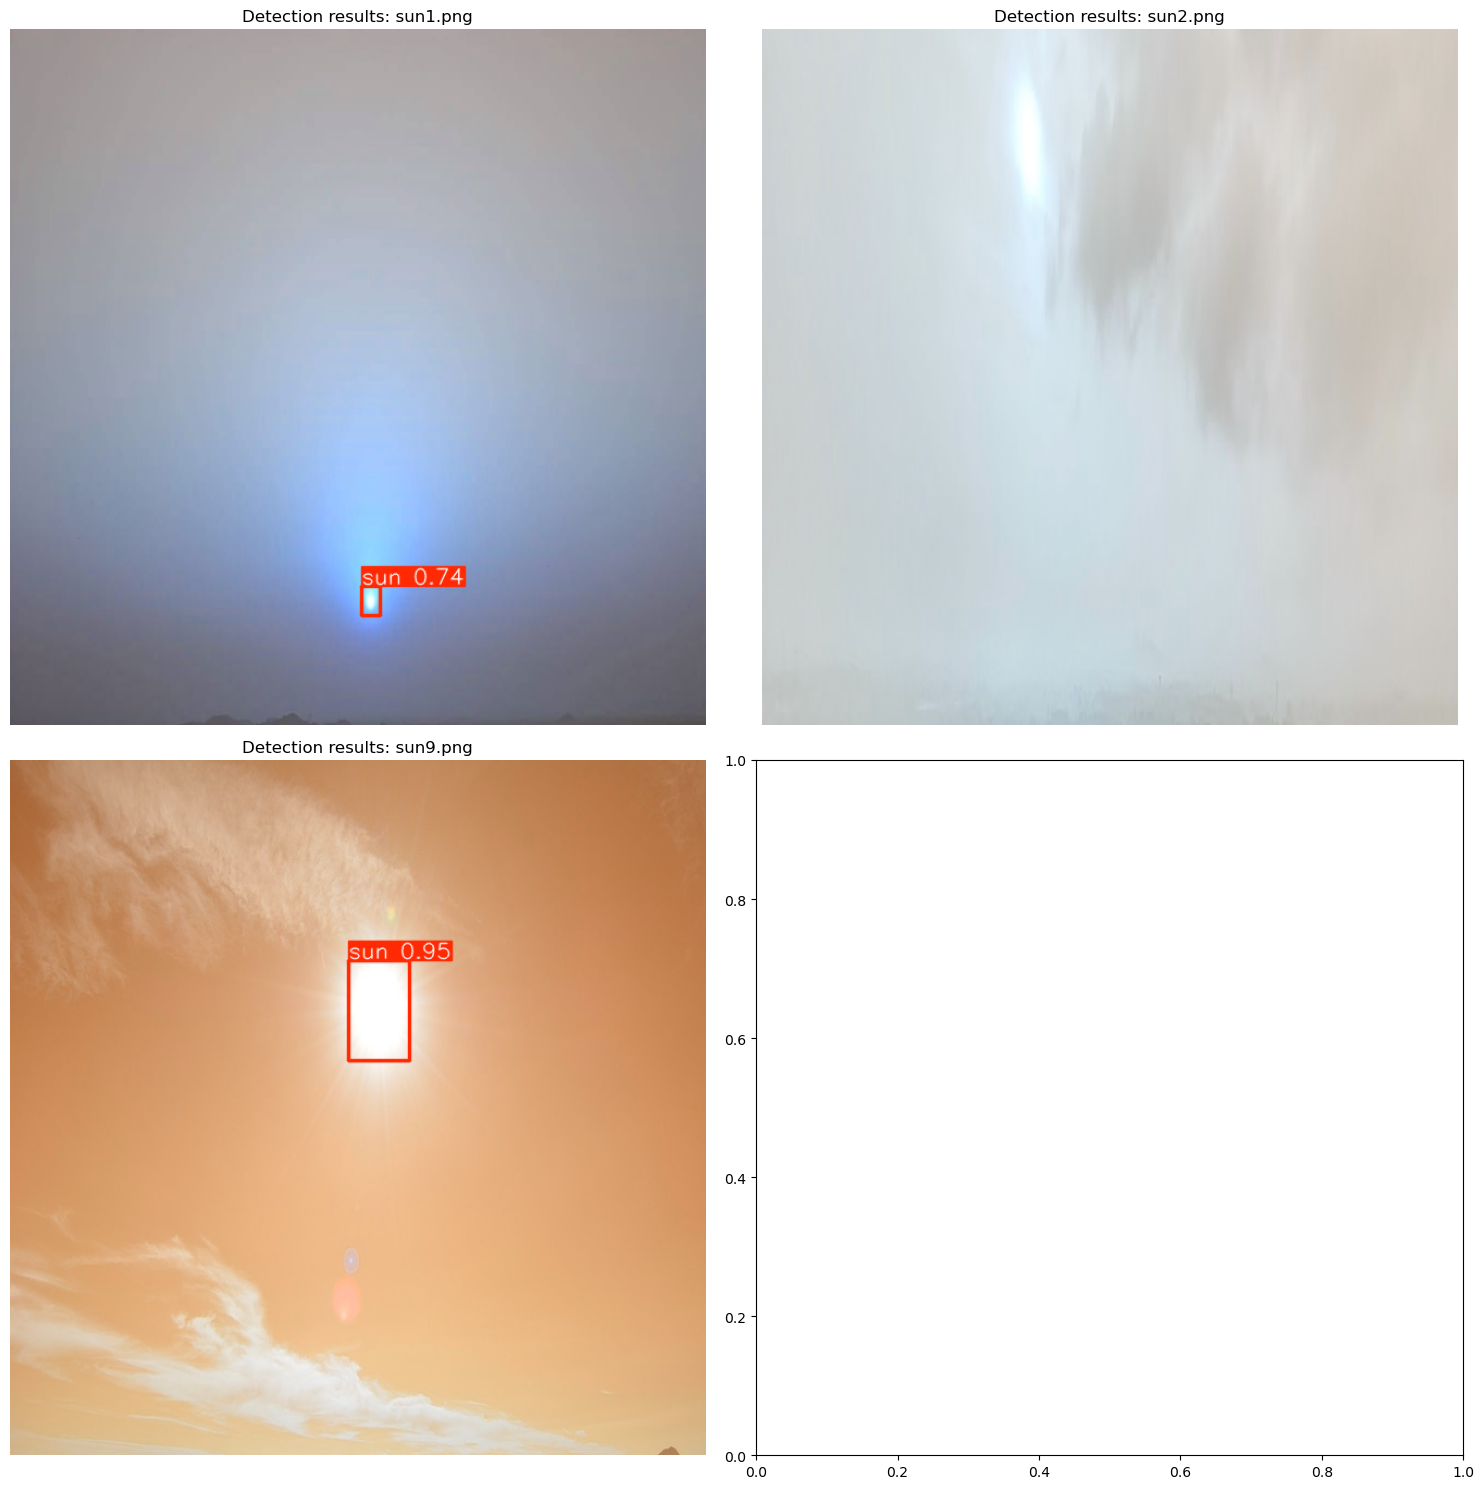

In [50]:
# ...existing code...

# %%
# Visualize predictions on validation data
from pathlib import Path
import matplotlib.pyplot as plt

# Get a few validation images
val_img_dir = Path(output_dir) / 'images' / 'val'
val_images = list(val_img_dir.glob('*.png'))[:4]  # Get first 4 validation images

# Create a subplot for each image
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.ravel()

for idx, img_path in enumerate(val_images):
    # Get predictions
    results = model.predict(str(img_path))
    
    # Plot the result
    res_plotted = results[0].plot()
    axes[idx].imshow(res_plotted)
    axes[idx].set_title(f'Detection results: {img_path.name}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

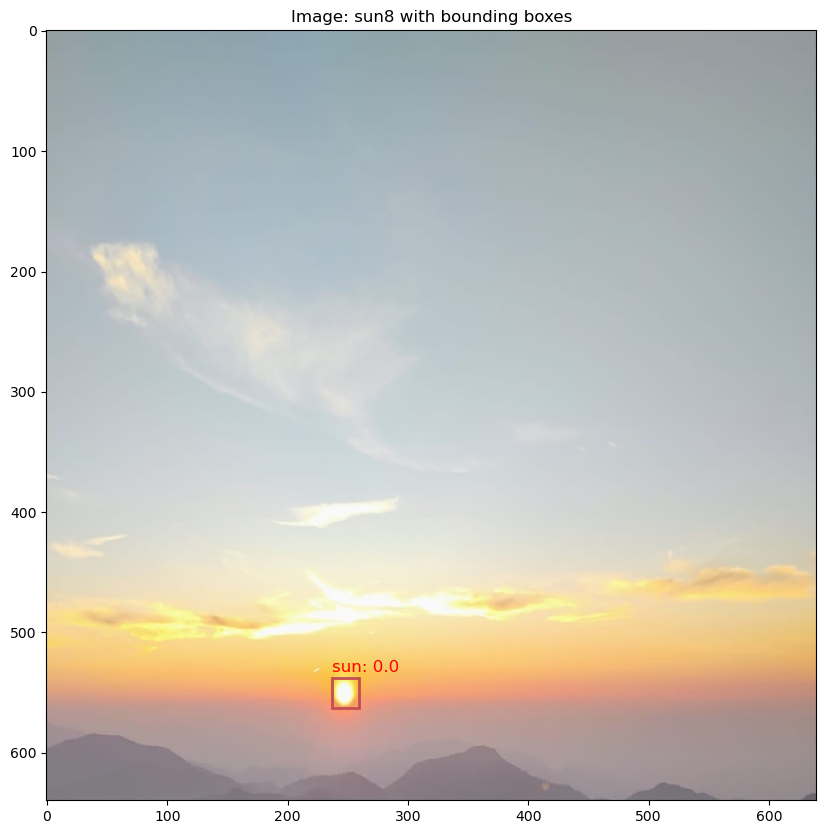

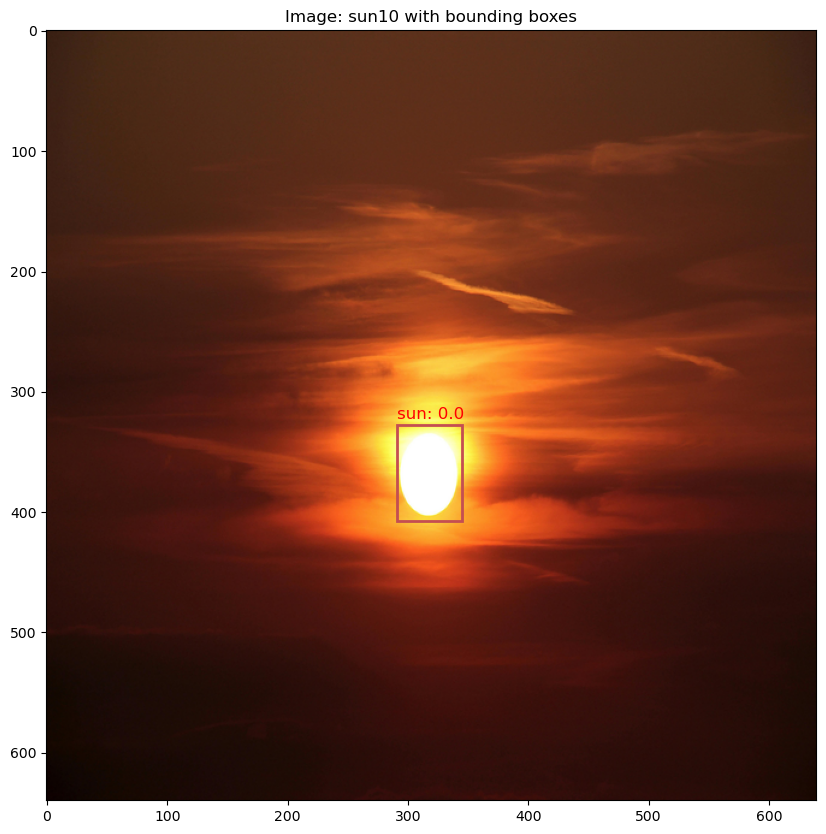

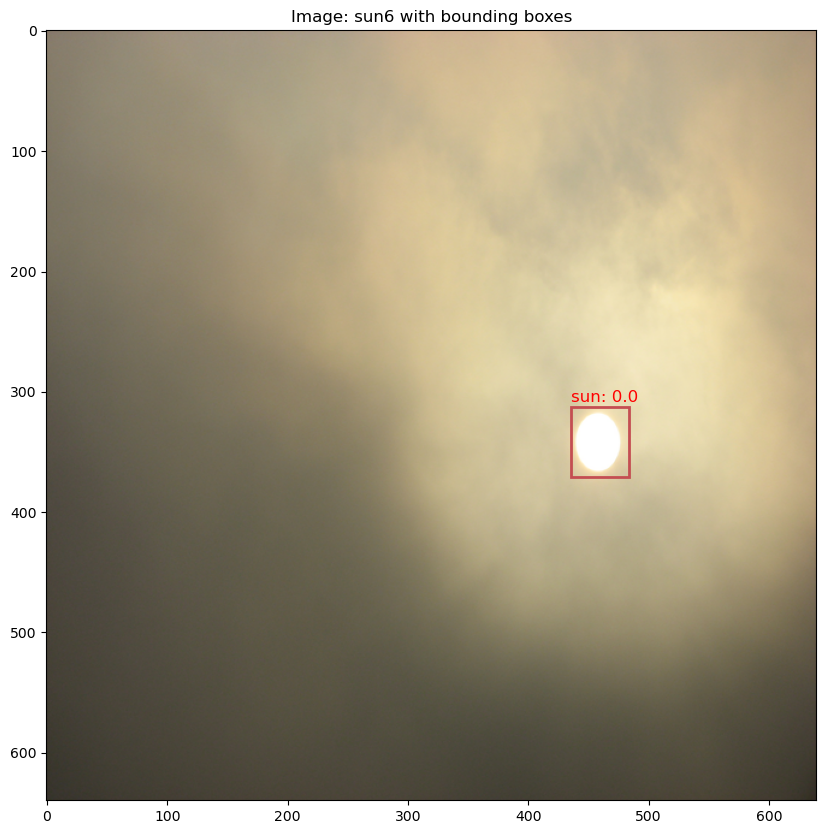

In [37]:
def visualize_labels(img_id, split='train'):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    # Load image
    img_path = os.path.join(image_out, split, img_id + '.png')
    img = Image.open(img_path)
    
    # Load label
    label_path = os.path.join(label_out, split, img_id + '.txt')
    with open(label_path, 'r') as f:
        labels = f.readlines()
    
    # Create figure and axis
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.imshow(img)
    
    # Convert YOLO format to box coordinates and draw
    for label in labels:
        cls_id, x_center, y_center, w, h = map(float, label.strip().split())
        x_center *= img_size[0]
        y_center *= img_size[1]
        w *= img_size[0]
        h *= img_size[1]
        
        x1 = x_center - w/2
        y1 = y_center - h/2
        
        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, 
                               edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # Add label text
        plt.text(x1, y1-5, f'sun: {cls_id}', color='red', fontsize=12)
    
    plt.axis('on')
    plt.title(f'Image: {img_id} with bounding boxes')
    plt.show()

# Test on first few training images
for img_id in train_ids[:3]:  # Show first 3 images
    visualize_labels(img_id)
    plt.close()  # Clear the current figure

In [44]:
%matplotlib inline

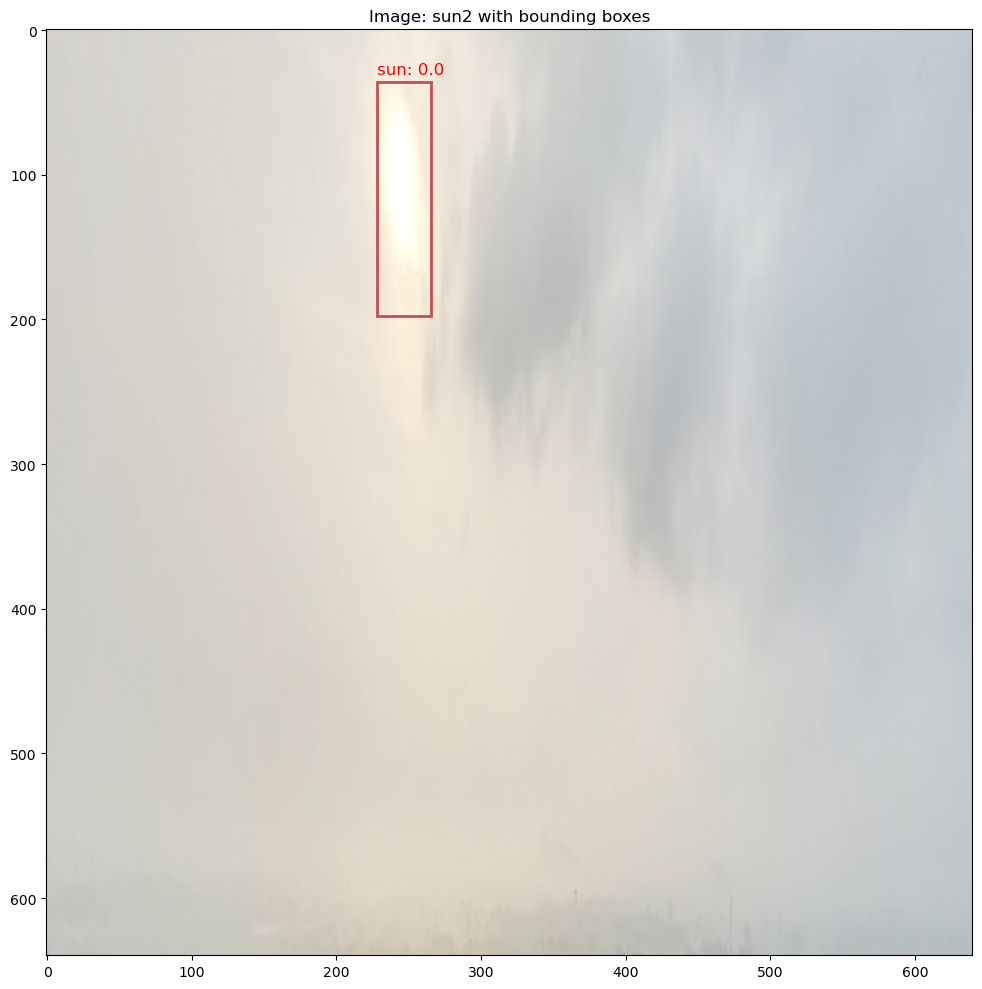

In [39]:
def visualize_labels(img_id, split='val'):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    # Load image
    img_path = os.path.join(image_out, split, img_id + '.png')
    img = Image.open(img_path)
    
    # Load label
    label_path = os.path.join(label_out, split, img_id + '.txt')
    with open(label_path, 'r') as f:
        labels = f.readlines()
    
    # Create figure and axis with specific DPI for better display
    plt.figure(figsize=(10, 10), dpi=100)
    ax = plt.gca()
    ax.imshow(img)
    
    # Convert YOLO format to box coordinates and draw
    for label in labels:
        cls_id, x_center, y_center, w, h = map(float, label.strip().split())
        x_center *= img_size[0]
        y_center *= img_size[1]
        w *= img_size[0]
        h *= img_size[1]
        
        x1 = x_center - w/2
        y1 = y_center - h/2
        
        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, 
                               edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x1, y1-5, f'sun: {cls_id}', color='red', fontsize=12)
    
    plt.axis('on')
    plt.title(f'Image: {img_id} with bounding boxes')
    plt.tight_layout()
    plt.show()
    plt.close()  # Clear the figure after showing

# Test visualization on one image at a time
if val_ids:
    visualize_labels(val_ids[-1])


image 1/1 c:\Users\karth\OneDrive\Documents\GitHub\Solar_git\gk_stuff\images\yolo_dataset\images\val\sun1.png: 640x640 1 sun, 24.5ms
Speed: 3.5ms preprocess, 24.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\karth\OneDrive\Documents\GitHub\Solar_git\gk_stuff\images\yolo_dataset\images\val\sun2.png: 640x640 1 sun, 24.6ms
Speed: 3.8ms preprocess, 24.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\karth\OneDrive\Documents\GitHub\Solar_git\gk_stuff\images\yolo_dataset\images\val\sun9.png: 640x640 1 sun, 24.2ms
Speed: 3.6ms preprocess, 24.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


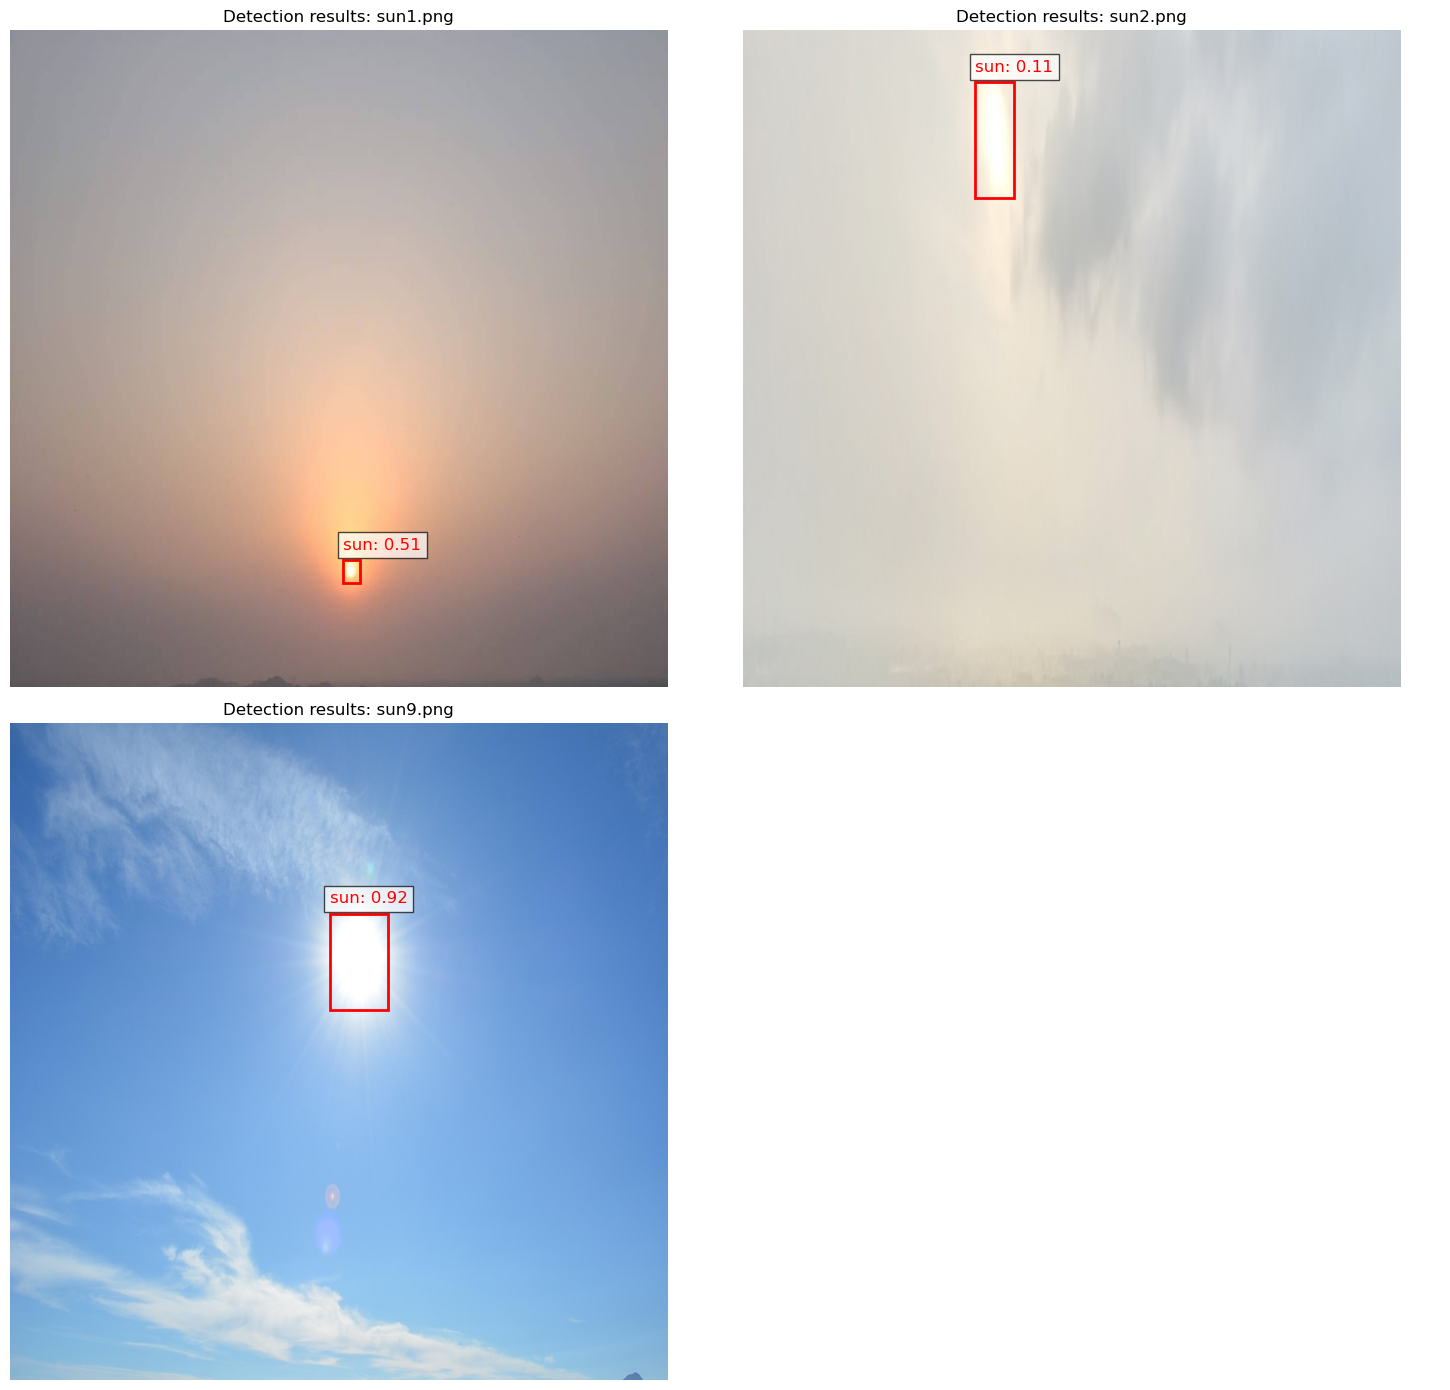

In [48]:
def visualize_predictions(model, num_images=4, conf_threshold=0.25):
    from pathlib import Path
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Get validation images
    val_img_dir = Path(output_dir) / 'images' / 'val'
    val_images = list(val_img_dir.glob('*.png'))[:num_images]
    
    # Create subplot grid
    rows = int(np.ceil(len(val_images) / 2))
    fig, axes = plt.subplots(rows, 2, figsize=(15, 7*rows))
    axes = axes.ravel() if len(val_images) > 2 else [axes] if len(val_images) == 1 else axes
    
    for idx, img_path in enumerate(val_images):
        # Get predictions with confidence threshold
        results = model.predict(str(img_path), conf=conf_threshold)[0]
        
        # Get the image and plot it
        img = plt.imread(str(img_path))
        axes[idx].imshow(img)
        
        # Plot each detection
        boxes = results.boxes
        for box in boxes:
            # Get box coordinates and confidence
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = float(box.conf[0].cpu().numpy())
            
            # Create rectangle patch
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                               fill=False, color='red', linewidth=2)
            axes[idx].add_patch(rect)
            
            # Add confidence text above box
            axes[idx].text(x1, y1-10, f'sun: {conf:.2f}',
                         color='red', fontsize=12, 
                         bbox=dict(facecolor='white', alpha=0.7))
        
        axes[idx].set_title(f'Detection results: {img_path.name}')
        axes[idx].axis('off')
    
    # Hide empty subplots if any
    for idx in range(len(val_images), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Run visualization with lower confidence threshold
visualize_predictions(model, conf_threshold=0.1)